In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import torchvision.transforms as transforms 
from torch.utils import data
import torch.optim as optim
import pickle
from torch.utils.tensorboard import SummaryWriter


import skimage
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np 
import pandas as pd
import os
import re
import glob
import seaborn as sns
from PIL import Image
import tqdm.notebook as tdnb
import tqdm
%matplotlib inline

In [2]:
test_image = imread("../brain_tumor_dataset/yes/Y3.jpg")

In [3]:
test_image = resize(test_image, (256, 256, 3))

In [4]:
out = test_image[None, ...]

In [5]:
out.shape

(1, 256, 256, 3)

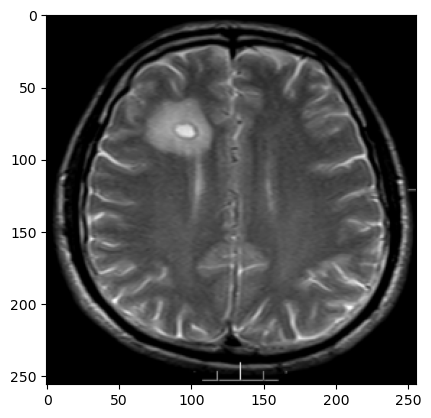

In [6]:
plt.imshow(out[0])

In [7]:
class ViTConfig:
    def __init__(self,
                 input_channels,
                 num_classes,
                 num_patches,
                 embedding_size,
                 patch_size,
                 num_heads,
                 num_blocks,
                 batch_size,
                 dropout=0.2,
                 precision=torch.float32):
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.num_patches = num_patches
        self.embedding_size = embedding_size
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.dropout = dropout
        self.precision = precision
        self.batch_size = batch_size

## Model Architecture Code starts here

## Transformer Encoder Code

In [8]:
class Head(nn.Module):
    def __init__(self, head_size, n_embd, block_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        # No need to do masked attention because we're not doing anything autoregressive
        # self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.value = nn.Linear(n_embd, head_size, bias=False)


    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = torch.matmul(q, k.transpose(-2, -1)) * k.shape[-1]**0.5
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)

        v = self.value(x)
        out = torch.matmul(wei, v)

        return out, wei


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout=0.2):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.attention_probs = None
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, x):
        attention_outs = [h(x) for h in self.heads]
        attention_out = torch.cat([output for output, _ in attention_outs], dim=-1)
        attention_out = self.proj(attention_out)
        attention_out = self.dropout(attention_out)
        self.attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outs], dim=1)
        return attention_out
        

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout=0.2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size):
        super().__init__()
        head_size = n_embd // n_head
        self.multi_head = MultiHeadAttention(n_head, head_size, n_embd, block_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)


    def forward(self, x):
        x = x + self.multi_head(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    

class TransformerEncoder(nn.Module):
    def __init__(self, embedding_size, num_heads, num_blocks, block_size):
        super().__init__()
        self.blocks = nn.Sequential(
            *[Block(embedding_size, num_heads, block_size) for _ in range(num_blocks)]
        )
        
    def forward(self, x):
        return self.blocks(x)

## Vision Transformer Code

In [9]:

class PatchEmbedding(nn.Module):
    def __init__(self,
                input_channels,
                embedding_size,
                patch_size,
                batch_size,
                num_patches,
                precision):
        super().__init__()
        # Convert an image into patches
        self.sequence = nn.Sequential(
            nn.Conv2d(
                    in_channels=input_channels,
                    out_channels=embedding_size,
                    kernel_size=patch_size,
                    stride=patch_size,
                    dtype=precision,
                    device=device
                ),
            nn.Flatten(2),
        )
        
        self.cls_tkn_embd = nn.Parameter(
                                    torch.randn(size=(batch_size, 1, embedding_size), device=device),
                                    requires_grad=True)
        self.pos_embd = nn.Parameter(
                                    torch.randn(size=(1,  num_patches + 1,  embedding_size), device=device),
                                    requires_grad=True)


    def forward(self, x):
        x = self.sequence(x).permute(0, 2, 1)
        x = torch.cat([self.cls_tkn_embd, x], dim=1)
        x = x + self.pos_embd
        return x
    

class VisionTransformer(nn.Module):
    def __init__(self,
                config: ViTConfig):
        super().__init__()
        
        self.embeddings = PatchEmbedding(
                input_channels=config.input_channels,
                embedding_size=config.embedding_size,
                patch_size=config.patch_size,
                num_patches=config.num_patches,
                precision=config.precision,
                batch_size=config.batch_size
        )
        
        self.transformer_encoder = TransformerEncoder(
            embedding_size=config.embedding_size,
            num_heads=config.num_heads,
            num_blocks=config.num_blocks,
            block_size=config.num_patches+1,
        )
        
        self.mlp = nn.Sequential(
            nn.Linear(config.embedding_size, 4*config.embedding_size),
            nn.GELU(),
            nn.LayerNorm(4*config.embedding_size),
            nn.Linear(4*config.embedding_size, config.num_classes)
        )


    def forward(self, x):
        x = self.embeddings(x)
        x = self.transformer_encoder(x)
        return self.mlp(x[:, 0, :])

## Config File for ViT

## Brain Tumor Dataset

In [10]:
base_dir = "../brain_tumor_dataset/"
labels = os.listdir(base_dir)

In [11]:
import random

In [12]:
class BrainTumorDataset(data.Dataset):
    def __init__(self, data_dir, train=True, test_size=0.2, transform=None, random_state=42):
        labels = os.listdir(data_dir)
        self.transform = transform
        self.data_dir = data_dir
        self.class_encoding = {k:v for k,v in enumerate(labels)}
        
        images = []
        for i in range(len(labels)):
            cur_dir_imgs = os.listdir(os.path.join(base_dir, labels[i]))
            cur_dir_imgs = [os.path.join(base_dir,labels[i], curr) for curr in cur_dir_imgs]
            images += list(zip(cur_dir_imgs, [i]*len(cur_dir_imgs)))
            
        data = pd.DataFrame(images, columns=["image", "class"])
        tr_x, ts_x, tr_y, ts_y = train_test_split(data[["image"]], data[['class']],
                                                 test_size=test_size, stratify=data[["class"]],
                                                 random_state=random_state)
        self.train = pd.concat([tr_x, tr_y], axis=1)
        self.test = pd.concat([ts_x, ts_y], axis=1)
        self.indexer = self.train if train else self.test
        
    def __len__(self):
        return self.indexer.shape[0]
        
    def __getitem__(self, idx):
        image_dir, label = self.indexer.iloc[idx]
        image = Image.open(image_dir)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [13]:
input_channels = 3 # 1 for Gray Scale Imgs and 3 for RGB
num_classes = 10
p_embd_size = 8
batch_size = 50
img_size = 256
kernel_size = 16
n_patches = (img_size // kernel_size)**2
fp = torch.float32
eval_iter = 1

lr = 0.01
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Convert to 3 channels if not already
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Loading CIFAR100 dataset for pre-training

In [15]:
from torchvision.datasets import CIFAR10

In [16]:
training_dataset = CIFAR10(root="../cifar10/", download=True, transform=transform)

Files already downloaded and verified


In [17]:
test_dataset = CIFAR10(root="../cifar10/", download=True, train=False, transform=transform)

Files already downloaded and verified


In [18]:
# training_dataset = BrainTumorDataset(data_dir="../brain_tumor_dataset/", random_state=123, train=True, transform=transform)
# test_dataset = BrainTumorDataset(data_dir="../brain_tumor_dataset/", random_state=123, train=False, transform=transform)

In [19]:
train_loader = data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

In [20]:
@torch.no_grad
def evaluate(model, test_loader, eval_func, avg=None):
    model.eval()
    accuracy = 0.0
    for batch in test_loader:
        tensors, labels = batch
        tensors, labels = tensors.to(device), labels.to(device)
        logits = model(tensors)
        predictions = torch.argmax(logits, axis=-1).to('cpu')
        labels = labels.to('cpu')
        if avg is None:
            accuracy += eval_func(labels, predictions)
        else:
            accuracy += eval_func(labels, predictions, average=avg, zero_division=0.0)
    model.train()
    return accuracy / len(test_loader)

In [21]:
config = ViTConfig(
    input_channels=input_channels,
    num_classes=num_classes,
    embedding_size=p_embd_size,
    patch_size=kernel_size,
    num_patches=n_patches,
    num_heads=8,
    num_blocks=8,
    precision=fp,
    batch_size=batch_size
)

In [22]:
def search_checkpoint(dir):
    epochs = glob.glob(os.path.join(dir,"*.pt"))
    if len(epochs) == 0:
        return None
    epochs = [os.path.basename(e) for e in epochs]
    epochs = [int(re.match(r"([\d]*)(?=.pt)", names).group(1)) for names in epochs]
    return max(epochs)

checkpoint_dir = "../checkpoints"
log_dir = "../logs"

if not os.path.exists(checkpoint_dir):
    print("Creating Checkpoint Directory...")
    os.mkdir(checkpoint_dir)
if not os.path.exists(log_dir):
    print("Creating Logs Directory...")
    os.mkdir(checkpoint_dir)

saved_epoch = search_checkpoint(checkpoint_dir)

if saved_epoch is None:
    model = VisionTransformer(config)
    saved_epoch = 0
    print(f"Checkpoint Not Found. Loading model from epoch {saved_epoch}")
else:
    print(f"Checkpoint Found. Loading model from epoch {saved_epoch}")
    model_path = os.path.join(checkpoint_dir, f"{saved_epoch}.pt")
    model = torch.load(model_path)


model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

Checkpoint Not Found. Loading model from epoch 0


In [ ]:
writer = SummaryWriter(log_dir=log_dir, flush_secs=10)

iter = 0
for epoch in range(saved_epoch, epochs + 1):
    running_loss = 0.0
    with tqdm.tqdm(total=len(train_loader), desc=f"Epoch {epoch}/{(epochs + 1)}", leave=True) as pbar:
        for batch in train_loader:
            tensors, labels = batch
            tensors, labels = tensors.to(device), labels.to(device)
            logits = model(tensors)
            loss = criterion(logits, labels)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            # print(f"Epoch {epoch}, curr loss: {loss.item()}")
            loss = loss.item()
            writer.add_scalar("Loss/train_batch", loss, iter)
            running_loss += loss
            pbar.update(1)
            iter += 1
    acc = evaluate(model, test_loader, accuracy_score).round(2)
    pre = evaluate(model, test_loader, precision_score, avg='weighted').round(2)
    rec = evaluate(model, test_loader, recall_score, avg='weighted').round(2)
    torch.save(model, os.path.join(checkpoint_dir, f"{epoch}.pt"))
    # if epoch % eval_iter == 0 and epoch > 0:
    print(f"Epoch {epoch}, \
            curr loss: {running_loss}, \
            mean_accuracy: {acc}, \
            mean_precision: {pre}, \
            mean_recall: {rec}")

Epoch 0/101:   0%|                                                    | 0/1000 [00:00<?, ?it/s]/home/sid/miniconda3/envs/makemore/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 0/101: 100%|█████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.50it/s]


Epoch 0,             curr loss: 2030.9642030000687,             mean_accuracy: 0.31,             mean_precision: 0.3,             mean_recall: 0.31


Epoch 1/101: 100%|█████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


Epoch 1,             curr loss: 1761.0724483728409,             mean_accuracy: 0.33,             mean_precision: 0.37,             mean_recall: 0.33


Epoch 2/101: 100%|█████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


Epoch 2,             curr loss: 1656.8593393564224,             mean_accuracy: 0.39,             mean_precision: 0.43,             mean_recall: 0.4


Epoch 3/101: 100%|█████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.51it/s]


Epoch 3,             curr loss: 1604.3891299962997,             mean_accuracy: 0.42,             mean_precision: 0.45,             mean_recall: 0.42


Epoch 4/101: 100%|█████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.46it/s]


Epoch 4,             curr loss: 1546.6823842525482,             mean_accuracy: 0.44,             mean_precision: 0.49,             mean_recall: 0.44


Epoch 5/101: 100%|█████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


Epoch 5,             curr loss: 1492.25255048275,             mean_accuracy: 0.45,             mean_precision: 0.49,             mean_recall: 0.45


Epoch 6/101: 100%|█████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


Epoch 6,             curr loss: 1458.1554270982742,             mean_accuracy: 0.47,             mean_precision: 0.5,             mean_recall: 0.47


Epoch 7/101: 100%|█████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.50it/s]


Epoch 7,             curr loss: 1417.3779348134995,             mean_accuracy: 0.49,             mean_precision: 0.53,             mean_recall: 0.49


Epoch 8/101: 100%|█████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


Epoch 8,             curr loss: 1394.062697172165,             mean_accuracy: 0.49,             mean_precision: 0.55,             mean_recall: 0.49


Epoch 9/101: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.50it/s]


Epoch 9,             curr loss: 1370.643422782421,             mean_accuracy: 0.51,             mean_precision: 0.55,             mean_recall: 0.51


Epoch 10/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.36it/s]


Epoch 10,             curr loss: 1347.5954337716103,             mean_accuracy: 0.51,             mean_precision: 0.56,             mean_recall: 0.51


Epoch 11/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


Epoch 11,             curr loss: 1334.8971232771873,             mean_accuracy: 0.52,             mean_precision: 0.56,             mean_recall: 0.52


Epoch 12/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


Epoch 12,             curr loss: 1315.8122808337212,             mean_accuracy: 0.53,             mean_precision: 0.58,             mean_recall: 0.53


Epoch 13/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


Epoch 13,             curr loss: 1297.0986300110817,             mean_accuracy: 0.53,             mean_precision: 0.56,             mean_recall: 0.52


Epoch 14/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


Epoch 14,             curr loss: 1286.8003564476967,             mean_accuracy: 0.53,             mean_precision: 0.58,             mean_recall: 0.53


Epoch 15/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.46it/s]


Epoch 15,             curr loss: 1277.0190578699112,             mean_accuracy: 0.53,             mean_precision: 0.58,             mean_recall: 0.53


Epoch 16/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.39it/s]


Epoch 16,             curr loss: 1266.5946999192238,             mean_accuracy: 0.55,             mean_precision: 0.59,             mean_recall: 0.55


Epoch 17/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.51it/s]


Epoch 17,             curr loss: 1256.0001295804977,             mean_accuracy: 0.55,             mean_precision: 0.61,             mean_recall: 0.55


Epoch 18/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


Epoch 18,             curr loss: 1248.1323947310448,             mean_accuracy: 0.55,             mean_precision: 0.6,             mean_recall: 0.55


Epoch 19/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


Epoch 19,             curr loss: 1241.6448519825935,             mean_accuracy: 0.56,             mean_precision: 0.6,             mean_recall: 0.56


Epoch 20/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


Epoch 20,             curr loss: 1225.542052090168,             mean_accuracy: 0.56,             mean_precision: 0.61,             mean_recall: 0.56


Epoch 21/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.46it/s]


Epoch 21,             curr loss: 1220.9236077666283,             mean_accuracy: 0.54,             mean_precision: 0.59,             mean_recall: 0.54


Epoch 22/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.52it/s]


Epoch 22,             curr loss: 1221.5131095051765,             mean_accuracy: 0.56,             mean_precision: 0.6,             mean_recall: 0.56


Epoch 23/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.51it/s]


Epoch 23,             curr loss: 1208.560722708702,             mean_accuracy: 0.57,             mean_precision: 0.62,             mean_recall: 0.57


Epoch 24/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.49it/s]


Epoch 24,             curr loss: 1200.4261095523834,             mean_accuracy: 0.57,             mean_precision: 0.62,             mean_recall: 0.57


Epoch 25/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.51it/s]


Epoch 25,             curr loss: 1200.719587624073,             mean_accuracy: 0.58,             mean_precision: 0.61,             mean_recall: 0.57


Epoch 26/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.49it/s]


Epoch 26,             curr loss: 1196.8352633714676,             mean_accuracy: 0.58,             mean_precision: 0.62,             mean_recall: 0.58


Epoch 27/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.46it/s]


Epoch 27,             curr loss: 1193.1229696273804,             mean_accuracy: 0.58,             mean_precision: 0.62,             mean_recall: 0.58


Epoch 28/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.41it/s]


Epoch 28,             curr loss: 1185.020184993744,             mean_accuracy: 0.58,             mean_precision: 0.62,             mean_recall: 0.58


Epoch 29/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.45it/s]


Epoch 29,             curr loss: 1183.7134611010551,             mean_accuracy: 0.58,             mean_precision: 0.63,             mean_recall: 0.58


Epoch 30/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.40it/s]


Epoch 30,             curr loss: 1177.9540469646454,             mean_accuracy: 0.57,             mean_precision: 0.63,             mean_recall: 0.57


Epoch 31/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.35it/s]


Epoch 31,             curr loss: 1170.736894607544,             mean_accuracy: 0.59,             mean_precision: 0.63,             mean_recall: 0.59


Epoch 32/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.45it/s]


Epoch 32,             curr loss: 1167.6945630311966,             mean_accuracy: 0.58,             mean_precision: 0.63,             mean_recall: 0.58


Epoch 33/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.43it/s]


Epoch 33,             curr loss: 1164.3393297195435,             mean_accuracy: 0.57,             mean_precision: 0.63,             mean_recall: 0.57


Epoch 34/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


Epoch 34,             curr loss: 1155.8924900889397,             mean_accuracy: 0.59,             mean_precision: 0.64,             mean_recall: 0.59


Epoch 35/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


Epoch 35,             curr loss: 1161.7541259527206,             mean_accuracy: 0.6,             mean_precision: 0.64,             mean_recall: 0.6


Epoch 36/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.49it/s]


Epoch 36,             curr loss: 1153.0134634971619,             mean_accuracy: 0.6,             mean_precision: 0.64,             mean_recall: 0.59


Epoch 37/101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [6:27:38<00:00, 23.26s/it]


Epoch 37,             curr loss: 1155.209480702877,             mean_accuracy: 0.59,             mean_precision: 0.63,             mean_recall: 0.59


Epoch 38/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


Epoch 38,             curr loss: 1149.8053359389305,             mean_accuracy: 0.59,             mean_precision: 0.64,             mean_recall: 0.59


Epoch 39/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.47it/s]


Epoch 39,             curr loss: 1152.7282916903496,             mean_accuracy: 0.6,             mean_precision: 0.64,             mean_recall: 0.6


Epoch 40/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.46it/s]


Epoch 40,             curr loss: 1150.3527473211288,             mean_accuracy: 0.59,             mean_precision: 0.63,             mean_recall: 0.59


Epoch 41/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.54it/s]


Epoch 41,             curr loss: 1148.6736573576927,             mean_accuracy: 0.59,             mean_precision: 0.63,             mean_recall: 0.59


Epoch 42/101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:15:57<00:00,  4.56s/it]


Epoch 42,             curr loss: 1141.700554728508,             mean_accuracy: 0.59,             mean_precision: 0.64,             mean_recall: 0.6


Epoch 43/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.44it/s]


Epoch 43,             curr loss: 1138.0866279006004,             mean_accuracy: 0.58,             mean_precision: 0.63,             mean_recall: 0.58


Epoch 44/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:17<00:00,  7.26it/s]


Epoch 44,             curr loss: 1139.443315565586,             mean_accuracy: 0.59,             mean_precision: 0.64,             mean_recall: 0.59


Epoch 45/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.43it/s]


Epoch 45,             curr loss: 1134.726260125637,             mean_accuracy: 0.6,             mean_precision: 0.64,             mean_recall: 0.6


Epoch 46/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.43it/s]


Epoch 46,             curr loss: 1132.6295998096466,             mean_accuracy: 0.58,             mean_precision: 0.62,             mean_recall: 0.58


Epoch 47/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


Epoch 47,             curr loss: 1129.7626627087593,             mean_accuracy: 0.58,             mean_precision: 0.64,             mean_recall: 0.58


Epoch 48/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


Epoch 48,             curr loss: 1132.1366628408432,             mean_accuracy: 0.6,             mean_precision: 0.65,             mean_recall: 0.6


Epoch 49/101: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.43it/s]


Epoch 49,             curr loss: 1125.8485432863235,             mean_accuracy: 0.58,             mean_precision: 0.63,             mean_recall: 0.58


Epoch 50/101:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 538/1000 [05:00<8:46:35, 68.39s/it]

In [ ]:
plot = accuracy
ys = np.linspace(0, np.ceil(max(plot)),len(plot))
sns.lineplot(x=plot,y=ys)